**In this notebook, we demonstrate the application of basic Machine Learning Models and some basic Model Evaluation Metrics to perform classification task with Chicago Crime Dataset**

In general, An Ensemble Voting Model consist of Random Forest, Neural Network and KNN are used for the classification task of predicting the Type of Crime. Feel free to drop a comment and feedback.

In [152]:
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

In [153]:
df = pd.concat([pd.read_csv('../input/data-crimes-2021/Dataset_crimes.csv', error_bad_lines=False)], ignore_index=True)
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,12260346,JE102126,01/03/2021 01:23:00 PM,070XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,732,7,6.0,68,08B,1174496.0,1858251.0,2021,01/16/2021 03:49:23 PM,41.766435,-87.635964,"(41.766435144, -87.635963997)"
1,1,12263464,JE105797,01/03/2021 06:59:00 AM,080XX S YALE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,623,6,17.0,44,06,1176011.0,1851718.0,2021,01/16/2021 03:49:23 PM,41.748474,-87.630607,"(41.748473982, -87.630606588)"
2,2,12259990,JE101773,01/03/2021 12:20:00 AM,056XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,1513,15,29.0,25,08B,1138722.0,1900183.0,2021,01/16/2021 03:49:23 PM,41.882224,-87.766076,"(41.88222427, -87.766076162)"
3,5,12260241,JE101923,01/03/2021 08:54:00 AM,106XX S YATES AVE,0560,ASSAULT,SIMPLE,CHA APARTMENT,False,False,434,4,7.0,51,08A,1194343.0,1834995.0,2021,01/16/2021 03:49:23 PM,41.702154,-87.563980,"(41.702154047, -87.563980453)"
4,6,12260534,JE102382,01/03/2021 04:30:00 PM,013XX W TAYLOR ST,0820,THEFT,$500 AND UNDER,APARTMENT,True,True,1231,12,28.0,28,06,1167677.0,1895707.0,2021,01/16/2021 03:49:23 PM,41.869367,-87.659882,"(41.869367371, -87.659882148)"


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34225 entries, 0 to 34224
Data columns (total 23 columns):
Unnamed: 0              34225 non-null int64
ID                      34225 non-null int64
Case Number             34225 non-null object
Date                    34225 non-null object
Block                   34225 non-null object
IUCR                    34225 non-null object
Primary Type            34225 non-null object
Description             34225 non-null object
Location Description    33988 non-null object
Arrest                  34225 non-null bool
Domestic                34225 non-null bool
Beat                    34225 non-null int64
District                34225 non-null int64
Ward                    34223 non-null float64
Community Area          34225 non-null int64
FBI Code                34225 non-null object
X Coordinate            33939 non-null float64
Y Coordinate            33939 non-null float64
Year                    34225 non-null int64
Updated On              

In [155]:
# Preprocessing
# Remove NaN Value (As Dataset is huge, the NaN row could be neglectable)  
df = df.dropna()

In [156]:
# As the dataset is too huge is size, we would just subsampled a dataset for modelling as proof of concept
# df = df.sample(n=100000)

In [157]:
# Remove irrelevant/not meaningfull attributes
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['ID'], axis=1)
df = df.drop(['Case Number'], axis=1) 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33722 entries, 0 to 34224
Data columns (total 20 columns):
Date                    33722 non-null object
Block                   33722 non-null object
IUCR                    33722 non-null object
Primary Type            33722 non-null object
Description             33722 non-null object
Location Description    33722 non-null object
Arrest                  33722 non-null bool
Domestic                33722 non-null bool
Beat                    33722 non-null int64
District                33722 non-null int64
Ward                    33722 non-null float64
Community Area          33722 non-null int64
FBI Code                33722 non-null object
X Coordinate            33722 non-null float64
Y Coordinate            33722 non-null float64
Year                    33722 non-null int64
Updated On              33722 non-null object
Latitude                33722 non-null float64
Longitude               33722 non-null float64
Location            

In [158]:
# Splitting the Date to Day, Month, Year, Hour, Minute, Second
df['date2'] = pd.to_datetime(df['Date'])
df['Year'] = df['date2'].dt.year
df['Month'] = df['date2'].dt.month
df['Day'] = df['date2'].dt.day
df['Hour'] = df['date2'].dt.hour
df['Minute'] = df['date2'].dt.minute
df['Second'] = df['date2'].dt.second 
df = df.drop(['Date'], axis=1) 
df = df.drop(['date2'], axis=1) 
df = df.drop(['Updated On'], axis=1)
df.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location,Month,Day,Hour,Minute,Second
0,070XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,732,7,6.0,68,08B,1174496.0,1858251.0,2021,41.766435,-87.635964,"(41.766435144, -87.635963997)",1,3,13,23,0
1,080XX S YALE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,623,6,17.0,44,06,1176011.0,1851718.0,2021,41.748474,-87.630607,"(41.748473982, -87.630606588)",1,3,6,59,0
2,056XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,1513,15,29.0,25,08B,1138722.0,1900183.0,2021,41.882224,-87.766076,"(41.88222427, -87.766076162)",1,3,0,20,0
3,106XX S YATES AVE,0560,ASSAULT,SIMPLE,CHA APARTMENT,False,False,434,4,7.0,51,08A,1194343.0,1834995.0,2021,41.702154,-87.563980,"(41.702154047, -87.563980453)",1,3,8,54,0
4,013XX W TAYLOR ST,0820,THEFT,$500 AND UNDER,APARTMENT,True,True,1231,12,28.0,28,06,1167677.0,1895707.0,2021,41.869367,-87.659882,"(41.869367371, -87.659882148)",1,3,16,30,0


In [159]:
# Convert Categorical Attributes to Numerical
df['Block'] = pd.factorize(df["Block"])[0]
df['IUCR'] = pd.factorize(df["IUCR"])[0]
df['Description'] = pd.factorize(df["Description"])[0]
df['Location Description'] = pd.factorize(df["Location Description"])[0]
df['FBI Code'] = pd.factorize(df["FBI Code"])[0]
df['Location'] = pd.factorize(df["Location"])[0] 

In [160]:
Target = 'Primary Type'
print('Target: ', Target)

Target:  Primary Type


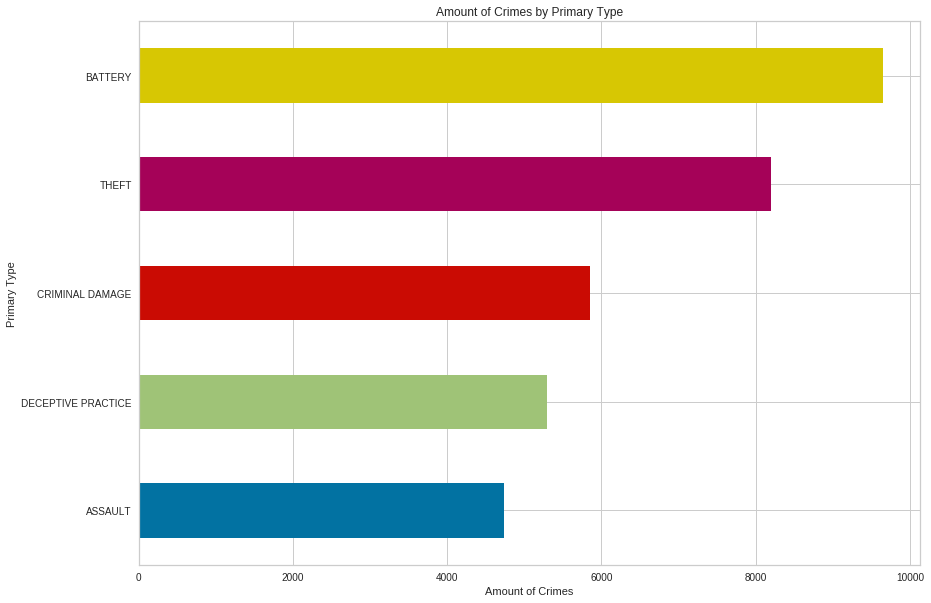

In [161]:
# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [162]:
# At previous plot, we could see that the classes is quite imbalance
# Therefore, we are going to group several less occured Crime Type into 'Others' to reduce the Target Class amount

# First, we sum up the amount of Crime Type happened and select the last 13 classes
all_classes = df.groupby(['Primary Type'])['Block'].size().reset_index()
all_classes['Amt'] = all_classes['Block']
all_classes = all_classes.drop(['Block'], axis=1)
all_classes = all_classes.sort_values(['Amt'], ascending=[False])

unwanted_classes = all_classes.tail(13)
unwanted_classes

,Primary Type,Amt
1,BATTERY,9648
4,THEFT,8197
2,CRIMINAL DAMAGE,5847
3,DECEPTIVE PRACTICE,5289
0,ASSAULT,4741


In [163]:
# # After that, we replaced it with label 'OTHERS'
# df.loc[df['Primary Type'].isin(unwanted_classes['Primary Type']), 'Primary Type'] = 'OTHERS'

# # Plot Bar Chart visualize Primary Types
# plt.figure(figsize=(14,10))
# plt.title('Amount of Crimes by Primary Type')
# plt.ylabel('Crime Type')
# plt.xlabel('Amount of Crimes')

# df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

# plt.show()

In [164]:
# Now we are left with 14 Class as our predictive class
Classes = df['Primary Type'].unique()
Classes

array(['BATTERY', 'THEFT', 'ASSAULT', 'CRIMINAL DAMAGE',
       'DECEPTIVE PRACTICE'], dtype=object)

In [165]:
#Encode target labels into categorical variables:
df['Primary Type'] = pd.factorize(df["Primary Type"])[0] 
df['Primary Type'].unique()

array([0, 1, 2, 3, 4])

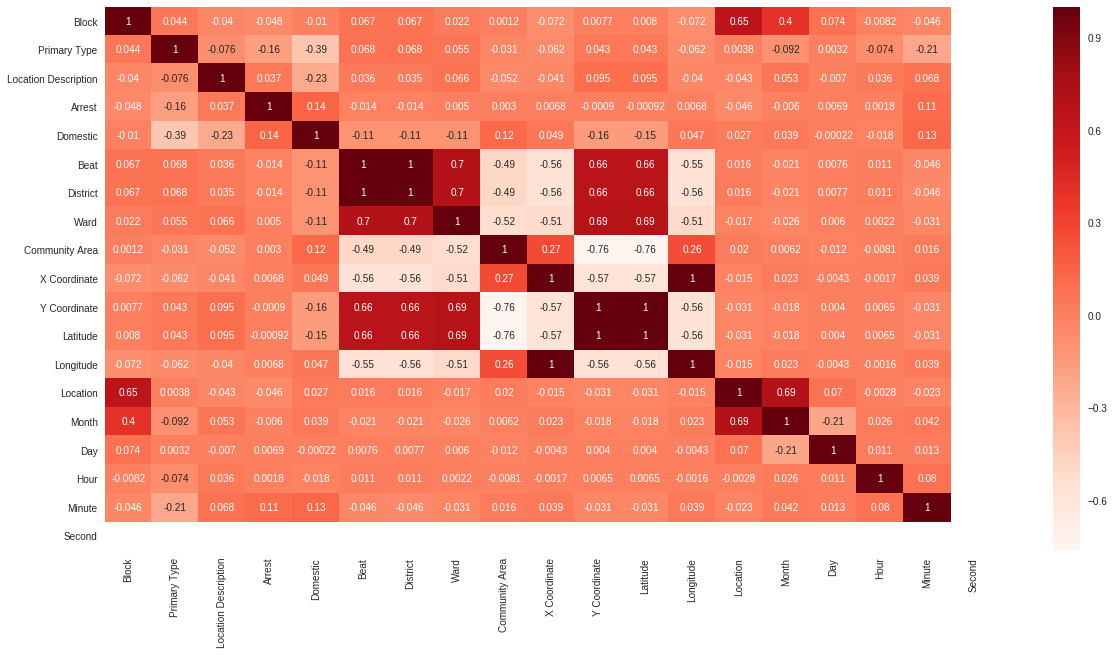

In [166]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
df = df.drop(['Description'], axis=1)
df = df.drop(['IUCR'], axis=1)
df = df.drop(['FBI Code'], axis=1)
df = df.drop(['Year'], axis=1)
X_fs = df.drop(['Primary Type'], axis=1)
Y_fs = df['Primary Type']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

**Further Elaboration of Correlation**

The correlation coefficient has values between -1 to 1
* A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
* A value closer to 1 implies stronger positive correlation
* A value closer to -1 implies stronger negative correlation

In [167]:
#Correlation with output variable
cor_target = abs(cor['Primary Type'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
relevant_features

Primary Type            1.000000
Location Description    0.075980
Arrest                  0.163426
Domestic                0.385343
Beat                    0.068056
District                0.068438
Ward                    0.055062
X Coordinate            0.061692
Longitude               0.061586
Month                   0.091938
Hour                    0.073858
Minute                  0.213371
Name: Primary Type, dtype: float64

In [168]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
Features = ["Arrest", "Domestic", "Minute", "X Coordinate", "Location Description", "Beat", "Month", "Hour", "Longitude", "Ward", "District"]
print('Full Features: ', Features)

Full Features:  ['Arrest', 'Domestic', 'Minute', 'X Coordinate', 'Location Description', 'Beat', 'Month', 'Hour', 'Longitude', 'Ward', 'District']


In [169]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(df, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[Target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[Target]      #Target Class to test

# print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Target Class        :  Primary Type
Training Set Size   :  (26977, 19)
Test Set Size       :  (6745, 19)


**Machine Learning Modelling**

In [170]:
# Random Forest
# Create Model with configuration
rf_model = RandomForestClassifier(n_estimators=1000, # Number of trees
#                                   min_samples_split = 20,
                                  bootstrap = True, 
                                  max_depth = 8)
#                                   min_samples_leaf = 5)

# Model Training
rf_model.fit(X=x1,
             y=x2)

# Prediction
result = rf_model.predict(y1)

In [171]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Random Forest Results ==========
Accuracy    :  0.5203854707190512
Recall      :  0.5203854707190512
Precision   :  0.4386053700449691
F1 Score    :  0.5203854707190512
Confusion Matrix: 
[[1412  379    0   88   63]
 [ 189 1142    0   76  220]
 [ 396  396    0   83   55]
 [ 299  553    0  150  149]
 [  36  231    0   22  806]]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================= Classification Report =================

                    precision    recall  f1-score   support

           BATTERY       0.61      0.73      0.66      1942
             THEFT       0.42      0.70      0.53      1627
           ASSAULT       0.00      0.00      0.00       930
   CRIMINAL DAMAGE       0.36      0.13      0.19      1151
DECEPTIVE PRACTICE       0.62      0.74      0.68      1095

         micro avg       0.52      0.52      0.52      6745
         macro avg       0.40      0.46      0.41      6745
      weighted avg       0.44      0.52      0.46      6745



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


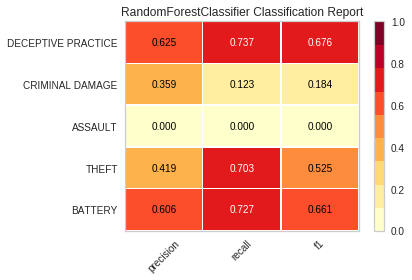

In [172]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [173]:
# Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(20,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=x1,
             y=x2)

# Prediction
result = nn_model.predict(y1) 

In [174]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Neural Network Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Neural Network Results ==========
Accuracy    :  0.2879169755374351
Recall      :  0.2879169755374351
Precision   :  0.08289618480262402
F1 Score    :  0.2879169755374351
Confusion Matrix: 
[[1942    0    0    0    0]
 [1627    0    0    0    0]
 [ 930    0    0    0    0]
 [1151    0    0    0    0]
 [1095    0    0    0    0]]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================= Classification Report =================

                    precision    recall  f1-score   support

           BATTERY       0.29      1.00      0.45      1942
             THEFT       0.00      0.00      0.00      1627
           ASSAULT       0.00      0.00      0.00       930
   CRIMINAL DAMAGE       0.00      0.00      0.00      1151
DECEPTIVE PRACTICE       0.00      0.00      0.00      1095

         micro avg       0.29      0.29      0.29      6745
         macro avg       0.06      0.20      0.09      6745
      weighted avg       0.08      0.29      0.13      6745



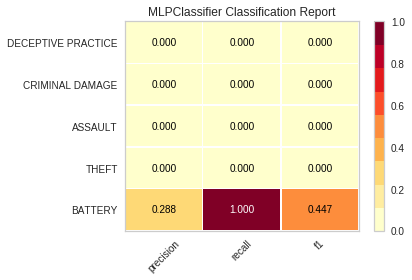

In [175]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(nn_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [176]:
# K-Nearest Neighbors
# Create Model with configuration 
knn_model = KNeighborsClassifier(n_neighbors=10)

# Model Training
knn_model.fit(X=x1,
             y=x2)

# Prediction
result = knn_model.predict(y1) 

In [177]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== K-Nearest Neighbors Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== K-Nearest Neighbors Results ==========
Accuracy    :  0.3393624907338769
Recall      :  0.3393624907338769
Precision   :  0.3191227018491469
F1 Score    :  0.3393624907338769
Confusion Matrix: 
[[1100  384  138  188  132]
 [ 591  696   69  145  126]
 [ 486  212   66   92   74]
 [ 570  238   94  174   75]
 [ 394  284   56  108  253]]


================= Classification Report =================

                    precision    recall  f1-score   support

           BATTERY       0.35      0.57      0.43      1942
             THEFT       0.38      0.43      0.40      1627
           ASSAULT       0.16      0.07      0.10       930
   CRIMINAL DAMAGE       0.25      0.15      0.19      1151
DECEPTIVE PRACTICE       0.38      0.23      0.29      1095

         micro avg       0.34      0.34      0.34      6745
         macro avg       0.30      0.29      0.28      6745
      weighted avg       0.32      0.34      0.31      6745



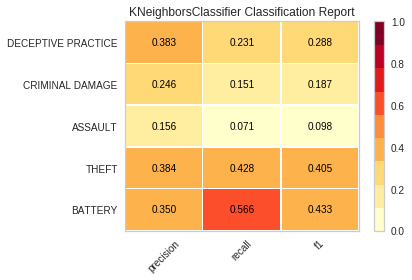

In [178]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(knn_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [179]:
# Ensemble Voting Model
# Combine 3 Models to create an Ensemble Model

# Create Model with configuration
eclf1 = VotingClassifier(estimators=[('knn', knn_model), ('rf', rf_model), ('nn', nn_model)], 
                         weights=[1,1,1],
                         flatten_transform=True)
eclf1 = eclf1.fit(X=x1, y=x2)   

# Prediction
result = eclf1.predict(y[Features])

In [180]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("============= Ensemble Voting Results =============")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

============= Ensemble Voting Results =============
Accuracy    :  0.38754633061527055
Recall      :  0.38754633061527055
Precision   :  0.4383434713680863
F1 Score    :  0.38754633061527055
Confusion Matrix: 
[[1804  121    0   10    7]
 [1025  563    0   13   26]
 [ 795  115    0    9   11]
 [ 947  157    0   32   15]
 [ 791   88    0    1  215]]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================= Classification Report =================

                    precision    recall  f1-score   support

           BATTERY       0.34      0.93      0.49      1942
             THEFT       0.54      0.35      0.42      1627
           ASSAULT       0.00      0.00      0.00       930
   CRIMINAL DAMAGE       0.49      0.03      0.05      1151
DECEPTIVE PRACTICE       0.78      0.20      0.31      1095

         micro avg       0.39      0.39      0.39      6745
         macro avg       0.43      0.30      0.26      6745
      weighted avg       0.44      0.39      0.30      6745



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


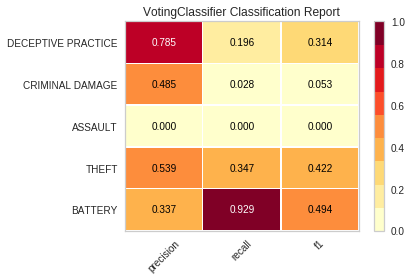

In [181]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(eclf1, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data